In [1]:
!pip install numerapi

In [2]:

!pip install vecstack;

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19878 sha256=0bb03a4013d944dab849c3a4d9f92f07235fe3254515b1e48208579ad7213d53
  Stored in directory: /root/.cache/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack


In [3]:
!pip install halo

  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11260 sha256=24f6f80086058a1120817931356aa505f30ef3a7aa400a768628ab7ad3867083
  Stored in directory: /root/.cache/pip/wheels/95/ff/20/5d16a0059f20c5e60be2df845201e73af179a5a79a3d566f48
Successfully built halo


In [4]:
import matplotlib
import os
import pathlib
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
import joblib
from tqdm.notebook import tqdm
from numerapi import NumerAPI
from halo import Halo
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt

In [5]:
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

In [6]:
napi = NumerAPI()
spinner = Halo(text='', spinner='dots')

In [7]:
current_round = napi.get_current_round(tournament=8)

In [8]:
napi.download_dataset("numerai_training_data.parquet", "numerai_training_data.parquet")
df = pd.read_parquet('numerai_training_data.parquet')
df.head()

2021-09-10 17:15:49,622 INFO numerapi.utils: starting download
numerai_training_data.parquet: 100%|█████████▉| 1.01G/1.01G [00:30<00:00, 57.1MB/s]

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,...,feature_oscillating_elaborated_mandatory,feature_contradictory_museful_somatotropin,feature_direst_interrupted_paloma,feature_congenerical_anodal_chelation,feature_pronominal_rampant_megaspore,feature_dropsical_suctorial_mnemosyne,feature_corrugated_dotiest_committeewoman,feature_architectonic_godlier_southland,feature_fishiest_simulatory_roadholding,feature_unpruned_pedagoguish_inkblot,feature_forworn_hask_haet,feature_drawable_exhortative_dispersant,feature_metabolic_minded_armorist,feature_investigatory_inerasable_circumvallation,feature_centroclinal_incentive_lancelet,feature_unemotional_quietistic_chirper,feature_behaviorist_microbiological_farina,feature_lofty_acceptable_challenge,feature_coactive_prefatorial_lucy,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,0.75,0.00,0.50,1.00,0.00,1.0,0.00,1.0,0.00,1.00,0.25,0.50,0.25,0.25,0.25,0.00,0.00,1.0,1.00,0.00,0.00,0.75,1.00,0.25,0.00,0.25,0.25,0.75,1.00,0.00,...,1.00,1.00,0.75,0.50,0.75,0.75,0.00,0.00,0.0,0.00,1.00,0.75,1.00,0.75,0.50,1.00,1.00,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.50,0.25,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,0.50,0.50,0.50,0.25,1.00,0.0,0.75,0.0,0.75,0.25,0.25,0.25,0.25,0.75,0.25,0.50,0.75,0.5,0.75,0.75,0.75,1.00,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.25,...,0.75,0.25,0.00,0.00,0.50,0.50,0.25,0.25,0.5,0.50,0.00,0.25,0.00,0.25,0.00,0.25,0.50,1.00,0.75,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.75,0.50,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,1.00,0.50,0.00,0.00,0.75,0.5,0.50,0.5,0.25,0.75,0.50,0.00,0.00,0.00,0.25,0.25,1.00,0.5,0.75,1.00,1.00,0.25,0.00,1.00,0.25,0.00,0.25,0.25,0.00,0.75,...,0.25,0.75,0.25,0.50,0.75,0.50,0.50,0.50,0.5,0.50,0.50,0.75,1.00,0.50,0.25,0.50,0.75,0.75,1.00,0.50,0.50,0.25,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.50,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,0.25,0.75,0.25,1.00,0.00,0.5,0.25,0.5,0.00,0.50,0.00,0.25,0.75,1.00,0.0

In [9]:
df.dtypes

era                                   object
data_type                             object
feature_dichasial_hammier_spawner    float32
feature_rheumy_epistemic_prancer     float32
feature_pert_performative_hormuz     float32
                                      ...   
target_william_60                    float32
target_arthur_20                     float32
target_arthur_60                     float32
target_thomas_20                     float32
target_thomas_60                     float32
Length: 1073, dtype: object

In [10]:
df.memory_usage(deep=True)

Index                                176083665
era                                  147138405
data_type                            149550510
feature_dichasial_hammier_spawner      9648420
feature_rheumy_epistemic_prancer       9648420
                                       ...    
target_william_60                      9648420
target_arthur_20                       9648420
target_arthur_60                       9648420
target_thomas_20                       9648420
target_thomas_60                       9648420
Length: 1074, dtype: int64

In [11]:
df.shape

(2412105, 1073)

In [12]:
# There's 1050 features with fun names generated by a hashing function
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.astype(int)
eras = df.erano
target = "target"

In [13]:
target = "target"
targets = [c for c in df if c.startswith("target")]
len(targets)

21

In [14]:
df[targets].corr()

,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
target,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,0.382948,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_20,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,0.382948,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_60,0.503147,0.503147,1.000000,0.433388,0.817732,0.373979,0.689912,0.456754,0.813261,0.384636,0.673598,0.423820,0.791360,0.409423,0.705469,0.464266,0.873005,0.468459,0.879774,0.492558,0.877989
target_jerome_20,0.769365,0.769365,0.433388,1.000000,0.463756,0.698353,0.382269,0.768737,0.426895,0.628114,0.353125,0.905954,0.446691,0.689335,0.379908,0.865786,0.453824,0.871040,0.457756,0.748965,0.421251
target_jerome_60,0.455448,0.455448,0.817732,0.463756,1.000000,0.382460,0.693168,0.450810,0.821748,0.372656,0.659323,0.451384,0.884963,0.408582,0.719172,0.457941,0.862257,0.459407,0.865918,0.447718,0.789250
target_janet_20,0.659012,0.659012,0.373979,0.698353,0.382460,1.000000,0.422820,0.641273,0.358757,0.718364,0.392251,0.703169,0.370593,0.576267,0.318308,0.724738,0.385911,0.747625,0.395341,0.648114,0.364063
target_janet_60,0.392255,0.392255,0.689912,0.382269,0.693168,0.422820,1.000000,0.378579,0.672070,0.414573,0.769956,0.374259,0.695526,0.341069,0.596787,0.388464,0.720954,0.395379,0.742915,0.386067,0.677794
target_ben_20,0.819540,0.819540,0.456754,0.768737,0.450810,0.641273,0.378579,1.000000,0.485953,0.655087,0.373347,0.745765,0.433137,0.757761,0.418228,0.746513,0.445281,0.755789,0.449744,0.872847,0.476992
target_ben_60,0.455063,0.455063,0.813261,0.426895,0.821748,0.358757,0.672070,0.485953,1.000000,0.373185,0.646430,0.416077,0.786051,0.425653,0.747294,0.424105,0.787089,0.427728,0.795083,0.480622,0.867900
target_alan_20,0.678464,0.678464,0.384636,0.628114,0.372656,0.718364,0.414573,0.655087,0.373185,1.000000,0.419483,0.614438,0.361734,0.581200,0.328936,0.642762,0.381904,0.661255,0.392130,0.702886,0.385541


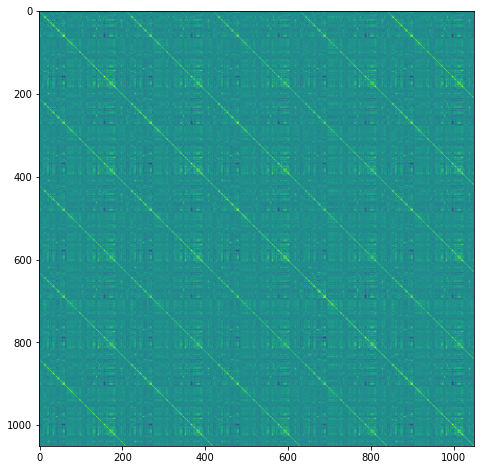

In [15]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.era=='0001'][features].corr())

In [16]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [17]:
# There are 574 eras numbered from 1 to 574
eras.describe()

count    2.412105e+06
mean     3.043023e+02
std      1.598982e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

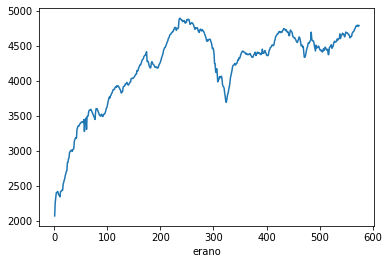

In [18]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [19]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
df.groupby(target).size()/len(df)

2021-09-10 17:33:41,299 INFO numexpr.utils: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-09-10 17:33:41,301 INFO numexpr.utils: NumExpr defaulting to 8 threads.


target
0.00    0.050003
0.25    0.199996
0.50    0.499993
0.75    0.200015
1.00    0.049992
dtype: float64

In [20]:
# Some new targets have a different distribution and the bins are less rigid in the percent of samples contained
print(df.groupby('target_william_20').size()/len(df))
print()
print(df.groupby('target_arthur_20').size()/len(df))

target_william_20
0.000000    0.029735
0.166667    0.059873
0.333333    0.211150
0.500000    0.391798
0.666667    0.203550
0.833333    0.065247
1.000000    0.038511
dtype: float64

target_arthur_20
0.000000    0.028859
0.166667    0.073267
0.333333    0.258668
0.500000    0.384931
0.666667    0.173287
0.833333    0.052486
1.000000    0.028367
dtype: float64


In [21]:
feature_corrs = df[df.era=='0001'][features].corr()

In [22]:
feature_corrs.stack().head()

feature_dichasial_hammier_spawner  feature_dichasial_hammier_spawner       1.000000
                                   feature_rheumy_epistemic_prancer        0.001690
                                   feature_pert_performative_hormuz        0.141253
                                   feature_hillier_unpitied_theobromine    0.170891
                                   feature_perigean_bewitching_thruster   -0.151098
dtype: float64

In [23]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_calycled_living_birmingham            feature_dentilingual_removed_osmometer             -0.947381
feature_criticisable_authentical_deprecation  feature_invalid_extortionary_titillation           -0.927235
feature_hierologic_assault_candida            feature_multicostate_undescended_monoacid          -0.926623
feature_apogamic_obeisant_pondicherry         feature_splitting_sexagesimal_teutonisation        -0.923430
feature_earthlier_parian_pistachio            feature_grandmotherly_circumnavigable_homonymity   -0.913526
                                                                                                    ...   
feature_horizontal_snug_description           feature_opposable_argumentative_mesoblast           1.000000
feature_brittle_chautauqua_elite              feature_neptunian_supersensitive_stapler            1.000000
feature_horizontal_snug_description           feature_juvenalian_paunchy_uniformitarianism        1.000000
feature_abstersive_emotional_misinter

In [ ]:
######################################################################
################ The correlation can change over time ################
######################################################################

In [24]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [25]:
feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][[target]+features].T)[1:,0])}

In [26]:
pd.Series(feature_scores).sort_values()

feature_unvaried_social_bangkok              -0.082876
feature_lofty_acceptable_challenge           -0.082876
feature_undivorced_unsatisfying_praetorium   -0.072182
feature_literate_treacly_altercation         -0.070247
feature_commensurable_industrial_jungfrau    -0.069840
                                                ...   
feature_apomictical_motorized_vaporisation    0.055358
feature_delimited_doable_jim                  0.056142
feature_durative_cuboidal_mirepoix            0.056497
feature_airborne_genitival_cathouse           0.058023
feature_alloyed_copyright_protium             0.059169
Length: 1050, dtype: float64

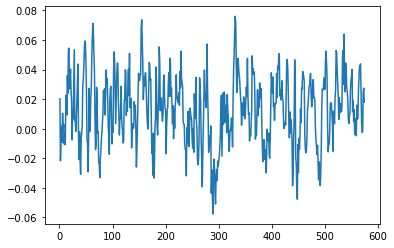

In [27]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_grandmotherly_circumnavigable_homonymity"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

In [28]:
df1

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,...,feature_contradictory_museful_somatotropin,feature_direst_interrupted_paloma,feature_congenerical_anodal_chelation,feature_pronominal_rampant_megaspore,feature_dropsical_suctorial_mnemosyne,feature_corrugated_dotiest_committeewoman,feature_architectonic_godlier_southland,feature_fishiest_simulatory_roadholding,feature_unpruned_pedagoguish_inkblot,feature_forworn_hask_haet,feature_drawable_exhortative_dispersant,feature_metabolic_minded_armorist,feature_investigatory_inerasable_circumvallation,feature_centroclinal_incentive_lancelet,feature_unemotional_quietistic_chirper,feature_behaviorist_microbiological_farina,feature_lofty_acceptable_challenge,feature_coactive_prefatorial_lucy,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60,erano
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.00,0.50,1.00,1.00,0.00,0.00,1.00,1.00,0.75,0.00,0.50,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.25,0.50,0.25,0.25,0.25,0.00,0.00,1.00,1.00,0.00,0.00,0.75,1.00,0.25,0.00,0.25,0.25,0.75,1.00,0.00,...,1.00,0.75,0.50,0.75,0.75,0.00,0.00,0.00,0.00,1.00,0.75,1.00,0.75,0.50,1.00,1.00,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.50,0.25,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000,1
n003bee128c2fcfc,0001,train,0.50,1.00,0.25,0.75,0.00,0.75,0.50,0.75,0.50,0.50,0.50,0.25,1.00,0.00,0.75,0.00,0.75,0.25,0.25,0.25,0.25,0.75,0.25,0.50,0.75,0.50,0.75,0.75,0.75,1.00,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.25,...,0.25,0.00,0.00,0.50,0.50,0.25,0.25,0.50,0.50,0.00,0.25,0.00,0.25,0.00,0.25,0.50,1.00,0.75,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.75,0.50,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667,1
n0048ac83aff7194,0001,train,0.50,0.25,0.75,0.00,0.75,0.00,0.75,0.75,1.00,0.50,0.00,0.00,0.75,0.50,0.50,0.50,0.25,0.75,0.50,0.00,0.00,0.00,0.25,0.25,1.00,0.50,0.75,1.00,1.00,0.25,0.00,1.00,0.25,0.00,0.25,0.25,0.00,0.75,...,0.75,0.25,0.50,0.75,0.50,0.50,0.50,0.50,0.50,0.50,0.75,1.00,0.50,0.25,0.50,0.75,0.75,1.00,0.50,0.50,0.25,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.50,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333,1
n00691bec80d3e02,0001,train,1.00,0.50,0.50,0.75,0.00,1.00,0.25,1.00,0.25,0.75,0.25,1.00,0.00,0.50,0.25,0.50,0.00,0.50,0.00,0.25,0.75,1.00,0.00,0.00,0.00,1.00,0.50,0.00

In [29]:
df2

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,...,feature_contradictory_museful_somatotropin,feature_direst_interrupted_paloma,feature_congenerical_anodal_chelation,feature_pronominal_rampant_megaspore,feature_dropsical_suctorial_mnemosyne,feature_corrugated_dotiest_committeewoman,feature_architectonic_godlier_southland,feature_fishiest_simulatory_roadholding,feature_unpruned_pedagoguish_inkblot,feature_forworn_hask_haet,feature_drawable_exhortative_dispersant,feature_metabolic_minded_armorist,feature_investigatory_inerasable_circumvallation,feature_centroclinal_incentive_lancelet,feature_unemotional_quietistic_chirper,feature_behaviorist_microbiological_farina,feature_lofty_acceptable_challenge,feature_coactive_prefatorial_lucy,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60,erano
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n000381ad0c8af9b,0305,train,0.00,0.75,0.25,0.75,0.25,0.75,0.75,0.00,0.00,0.50,0.75,1.00,1.00,1.00,1.00,1.00,1.00,0.50,1.00,0.50,0.75,0.50,0.75,1.00,0.25,0.00,0.00,0.50,0.50,0.75,0.50,0.25,0.75,1.00,0.75,1.00,0.75,0.75,...,0.00,0.50,0.75,0.50,0.00,0.50,0.50,0.75,0.75,0.00,1.00,0.25,0.50,0.25,0.50,0.50,1.00,1.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.666667,0.500000,0.500000,0.500000,0.500000,0.500000,305
n000ac54b6e92b06,0305,train,0.25,0.50,0.25,0.50,0.25,0.50,1.00,0.25,0.25,0.75,0.25,0.50,1.00,0.50,0.50,0.50,0.50,0.50,1.00,0.00,0.00,0.00,0.75,1.00,0.50,0.25,0.25,0.50,0.50,0.00,0.25,0.00,0.50,0.50,0.00,0.00,0.50,0.50,...,0.50,0.75,0.50,0.50,0.50,0.50,0.50,0.75,1.00,0.25,0.75,1.00,0.50,0.50,0.75,0.50,1.00,0.25,0.50,0.50,0.50,0.75,0.75,0.75,0.75,0.50,0.50,0.50,0.75,0.75,0.75,0.75,0.50,0.833333,0.666667,0.666667,0.666667,0.500000,0.500000,305
n002da3f2943306f,0305,train,0.75,0.25,0.75,0.75,0.50,0.50,0.75,1.00,0.25,0.50,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.75,0.25,0.75,0.25,0.50,0.25,0.25,0.50,0.75,0.75,0.50,0.50,1.00,1.00,1.00,0.25,0.75,0.75,0.75,0.75,0.25,...,0.50,1.00,0.00,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.75,0.50,0.50,0.75,0.75,0.25,0.25,0.25,0.75,0.75,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.50,0.50,0.50,0.50,0.666667,0.666667,0.500000,0.500000,0.500000,0.500000,305
n003ce01108ee7fe,0305,train,0.75,0.50,1.00,0.50,0.25,1.00,0.50,0.75,0.50,1.00,0.50,0.25,1.00,1.00,0.75,1.00,0.75,0.25,1.00,1.00,0.25,0.25,0.25,0.00,0.25,1.00,1.0

In [31]:
import gc

In [34]:
gc.collect()

41

In [35]:
napi.download_dataset("numerai_tournament_data.parquet", f"numerai_tournament_data_{current_round}.parquet")

2021-09-10 17:55:24,448 INFO numerapi.utils: starting download
numerai_tournament_data_280.parquet:  99%|█████████▉| 579M/582M [00:12<00:00, 57.9MB/s]

In [37]:
import pyarrow
import pyarrow.parquet as pq
from pyarrow.parquet import ParquetFile

In [43]:
filenames = f'numerai_tournament_data_{current_round}.parquet'

In [39]:
filename

'numerai_tournament_data_280.parquet'

In [ ]:
tournament_data = pd.read_parquet(f'numerai_tournament_data_{current_round}.parquet')

In [ ]:
#https://www.kaggle.com/jamesmcguigan/reading-parquet-files-ram-cpu-optimization

In [44]:
def read_parquet_via_pyarrow_file():
    pqfiles = [ ParquetFile(filename) for filename in filenames ]
    print( "sys.getsizeof", humanize.naturalsize(sys.getsizeof(pqfiles)) )
    for pqfile in pqfiles[0:1]: print(pqfile.metadata)
    return pqfiles

gc.collect();  # wait for gc to complete
read_parquet_via_pyarrow_file(); gc.collect()
print( "time: {time.time() - time_start:.1f}s" )
pass

FileNotFoundError: ignored